In [1]:
import sys
sys.path += [".."]

import smbh
import numpy as np
import matplotlib.pyplot as plt

In [15]:
import sympy as spy
spy.init_printing()

from IPython.display import display

In [155]:
def getPotential(density):
    global G, a_1, a_2, a_3, tau, m, x, y, z, m_int
    k = spy.symbols(r'k', real = True, positive = True)
    rho = density.subs(m, spy.sqrt(k))
    psi = -spy.integrate(rho, k)
    display(psi)
    psi = psi.subs(k, m ** 2)
    
    Phi = - spy.pi * G * (a_2 * a_3 / a_1) * psi * 1 / spy.sqrt((tau + a_1 ** 2) * (tau + a_2 ** 2) * (tau + a_3 ** 2))
    return Phi

def gradient(Phi):
    global a_1, a_2, a_3, x, y, z, m, m_int, phi_x, phi_y, phi_z, phi_1, phi_2, phi_3
    phi = Phi.subs(m, m_int)
    dim = [x, y, z]
    phis = [phi_x, phi_y, phi_z]
    phis_ = [phi_1, phi_2, phi_3]
    
    r = []
    for (x_i, phi_x_i, phi_i) in zip(dim, phis, phis_):
        t = phi.diff(x_i).subs(m_int / a_1, m / a_1).subs(m_int ** 2, m ** 2).simplify()
        t = (t / phi_x_i).factor()
        r.append(t)
        
    if r[0] == r[1]:
        factor = r[0]
        matrix = spy.Matrix(phis_)
    else: 
        factor = 1
        matrix = spy.Matrix(r)
    return factor, matrix

def toSpherical(phi):
    global a_1, a_2, a_3, x, y, z, r
    subs = [(a_1, 1), (a_2, 1), (a_3, 1), (x * x + y * y + z * z, r * r)]
    return phi.subs(subs)

def changeVariables(func):
    global tau
    return func.subs(tau, omega / (1 - omega)) / (1 - omega) ** 2

def gradToLatex(grad):
    new_m = r'm(\vec{x}, \tau)'
    latex = [spy.latex(g).replace('m ', new_m).replace(r'm\right)', new_m + r'\right)') for g in grad]
    txt = r"""\nabla \Phi = 
        \left(\begin{array}{l}
        %s, \\
        %s, \\
        %s
        \end{array}\right)""" % tuple(latex)
    print(txt)

# Potentials

In [298]:
G, tau, omega, gamma = spy.symbols(r'G \tau \omega \gamma', real = True, positive = True)
r, m, x, y, z, a_1, a_2, a_3, phi_1, phi_2, phi_3 = spy.symbols("r m x y z a_1 a_2 a_3 \phi_1 \phi_2 \phi_3",
                                                                real = True, positive = True)

m_int = [i ** 2 / (a ** 2 + tau) for (i, a) in zip([x, y, z], [a_1, a_2, a_3])]
m_int = spy.sqrt(a_1 ** 2 * sum(m_int))

phi_x = x / (spy.sqrt(tau + a_1 ** 2) ** 3 * spy.sqrt(tau + a_2 ** 2) * spy.sqrt(tau + a_3 ** 2))
phi_y = y / (spy.sqrt(tau + a_2 ** 2) ** 3 * spy.sqrt(tau + a_1 ** 2) * spy.sqrt(tau + a_3 ** 2))
phi_z = z / (spy.sqrt(tau + a_3 ** 2) ** 3 * spy.sqrt(tau + a_1 ** 2) * spy.sqrt(tau + a_2 ** 2))
# phi_x, phi_y, phi_z

# NFW

In [196]:
rho_0, R_s = spy.symbols(r"\rho_0 R_s", real = True, positive = True)

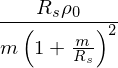

In [197]:
NFW = rho_0 / ((m / R_s) * (1 + m / R_s) ** 2)
NFW

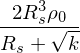

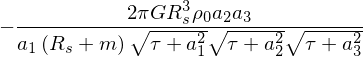

In [198]:
Phi = getPotential(NFW)
Phi

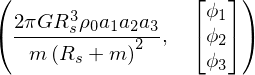

In [199]:
factor, matrix = gradient(Phi)
# gradToLatex(factor
factor, matrix

# Hernquist

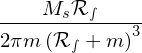

In [219]:
M_s, r_s = spy.symbols(r"M_s \mathcal{R_s}", real = True, positive = True)
Hernquist = M_s * r_s/ (2 * spy.pi * m * (m + r_s) ** 3)
Hernquist

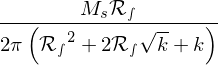

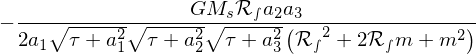

In [220]:
Phi = getPotential(Hernquist)
Phi

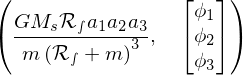

In [221]:
factor, matrix = gradient(Phi)
factor, matrix

# Power law

# Plots

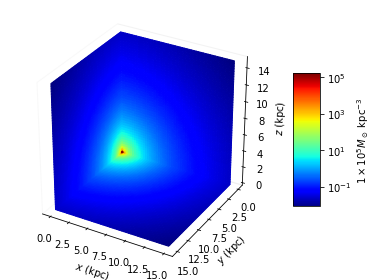

In [2]:
fig, ax, cbar = smbh.slice3d(1e-2, 15, smbh.darkMatterDensity, points = 50)

# fig.savefig("symmetric.png", dpi = 300)
plt.show()

In [15]:
smbh.setTriaxalCoeffs(1, 1, 1)

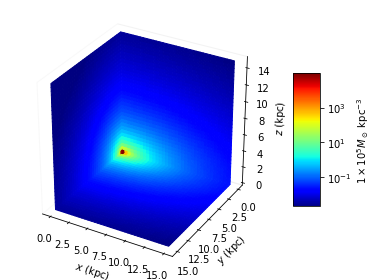

In [9]:
fig, ax, cbar = smbh.slice3d(1e-2, 15, smbh.darkMatterDensityTriaxial, symmetric = False)

# fig.savefig("triaxial.png", dpi = 300)
plt.show()

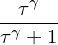

In [299]:
t = tau ** gamma / (1 + tau ** gamma)
t

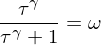

In [300]:
eq = spy.Eq(t, omega)
eq

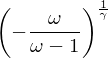

In [301]:
s0 = spy.solve(eq, tau)[0]
s0

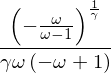

In [302]:
diff = s0.diff(omega).simplify()
diff

In [313]:
diff.subs(gamma, 0.1).simplify().subs(omega, 0)